In [1]:
!python --version

Python 3.11.11


In [2]:
import cv2 as cv
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip

class RoadSegmenter:
    def __init__(self, video_path: str, time_in_seconds: int):
        self.coordinates = []
        self.video = VideoFileClip(video_path)
        self.time_in_seconds = time_in_seconds
        self.frame = self.get_frame_at_time()
        if self.frame is None:
            raise ValueError("Unable to get the frame from the video.")
        self.gray_frame = cv.cvtColor(self.frame, cv.COLOR_BGR2GRAY)

    def get_frame_at_time(self) -> np.ndarray:
        frame = self.video.get_frame(self.time_in_seconds)
        return frame

    def get_coordinates(self, event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            self.coordinates.append((x, y))

    def segment(self) -> None:
        cv.namedWindow("Image", cv.WINDOW_NORMAL)
        cv.setMouseCallback("Image", self.get_coordinates)

        while True:
            frame_with_dots = self.gray_frame.copy()

            # Draw the points on the frame
            for (x, y) in self.coordinates:
                cv.circle(frame_with_dots, (x, y), 5, (255, 0, 0), -1)

            # Display a message for user guidance
            cv.putText(frame_with_dots, "Click to select coordinates", (10, 20), 
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv.LINE_AA)
            cv.putText(frame_with_dots, "Press 'r' to reset, 'q' to quit", (10, 50), 
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv.LINE_AA)

            cv.imshow("Image", frame_with_dots)

            key = cv.waitKey(1) & 0xFF

            if key == ord('q'):
                break
            elif key == ord('r'):
                self.coordinates = []

        cv.destroyAllWindows()

In [3]:
frame_in_second = 60 + 23
video_path = r"C:\Users\Auto\Downloads\south_morning.avi"

segmenter = RoadSegmenter(video_path, frame_in_second)
segmenter.segment()

In [4]:
segmenter.coordinates

[(1072, 340), (1536, 429), (1382, 1032), (4, 579)]

Density: 0.0000


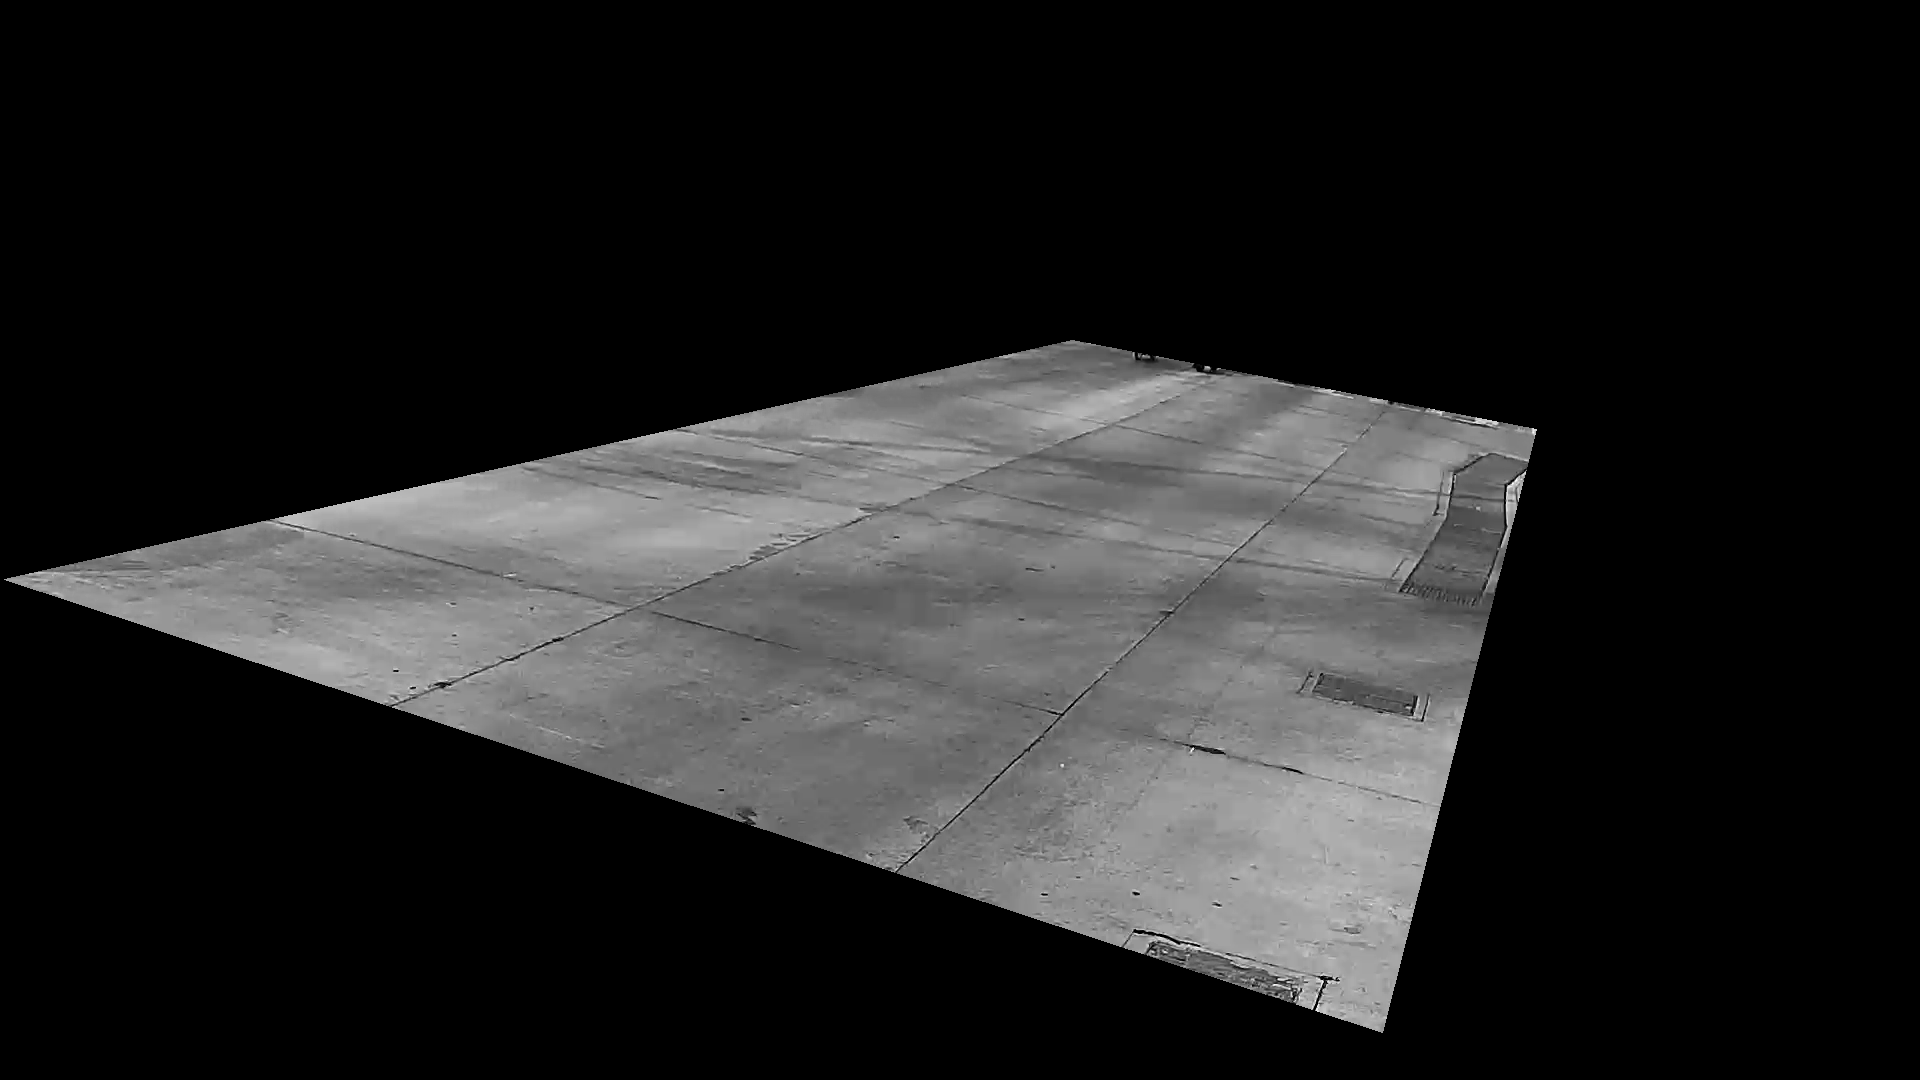

In [5]:
from PIL import Image

def segment_road(coordinates, frame):
    points = np.array(coordinates, dtype=np.int32)
    mask = np.zeros(frame.shape[:2], dtype=np.uint8)
    cv.fillPoly(mask, [points], 255)
    road_segment = cv.bitwise_and(frame, frame, mask=mask)
    return cv.cvtColor(road_segment, cv.COLOR_RGB2GRAY)

def calculate_density(road1, road2):
    # road1 = base frame (no car)
    # road2 = current frame (with car)
    hist_road1 = cv.calcHist([road1], [0], None, [256], [1, 255]).flatten()
    hist_road2 = cv.calcHist([road2], [0], None, [256], [1, 255]).flatten()
    hist_diff = np.maximum(hist_road1 - hist_road2, 0)
    density = np.sum(hist_diff) / np.sum(hist_road1)
    return density

base_road = segment_road(segmenter.coordinates, segmenter.frame)
print(f"Density: {calculate_density(road1=base_road, road2=base_road):.4f}")
image = Image.fromarray(base_road)
image

In [6]:
from tqdm import tqdm

cap = cv.VideoCapture(video_path)
h, w = segmenter.frame.shape[:2]
points = np.array(segmenter.coordinates, dtype=np.int32)

road_mask = np.zeros((h, w), dtype=np.uint8)
cv.fillPoly(road_mask, [points], 255)

hist_base = cv.calcHist([base_road], [0], None, [256], [1, 255]).flatten()
hist_base_sum = np.sum(hist_base)

data = []
cnt = 0
max_frames = 25 * 60 * 60 # 1 hour 90000 frames

with tqdm(total=max_frames, desc="Processing frames") as pbar:
    while cnt < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
        road = cv.bitwise_and(gray, gray, mask=road_mask)

        hist_cur = cv.calcHist([road], [0], None, [256], [1, 255]).flatten()
        density = np.maximum(hist_base - hist_cur, 0).sum() / hist_base_sum

        data.append({"frame_id": cnt, "density": density})

        cnt += 1
        pbar.update(1)

cap.release()

Processing frames: 100%|██████████| 90000/90000 [09:18<00:00, 161.27it/s]


In [9]:
import pandas as pd

df = pd.DataFrame(data)
df.head()

,frame_id,density
0,0,0.182453
1,1,0.181654
2,2,0.181559
3,3,0.181795
4,4,0.181966


In [11]:
df.to_csv("road_density.csv", index=False)

In [1]:
import pandas as pd

df = pd.read_csv("road_density.csv")
df.head()

,frame_id,density
0,0,0.182453
1,1,0.181654
2,2,0.181559
3,3,0.181795
4,4,0.181966


In [5]:
Y = df['density'].values.tolist()
Y[:10]

[0.18245278,
 0.18165433,
 0.1815588,
 0.18179491,
 0.18196614,
 0.18317012,
 0.18325844,
 0.18399923,
 0.18411097,
 0.18425696]

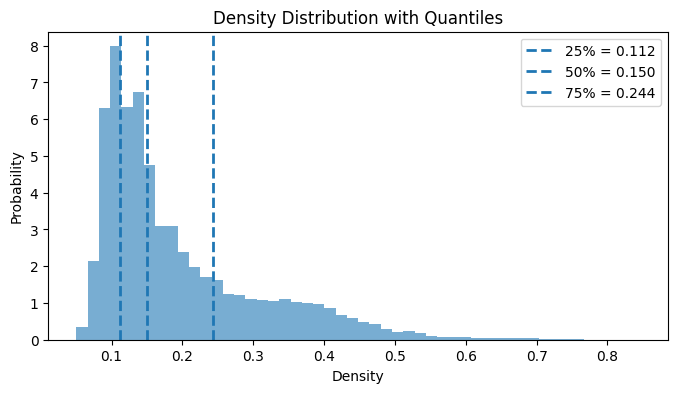

In [7]:
import matplotlib.pyplot as plt
import numpy as np

qs = [0.25, 0.5, 0.75]
q_vals = np.quantile(Y, qs)

plt.figure(figsize=(8, 4))
plt.hist(Y, bins=50, density=True, alpha=0.6)

for q, v in zip(qs, q_vals):
    plt.axvline(v, linestyle="--", linewidth=2, label=f"{int(q*100)}% = {v:.3f}")

plt.xlabel("Density")
plt.ylabel("Probability")
plt.title("Density Distribution with Quantiles")
plt.legend()
plt.show()

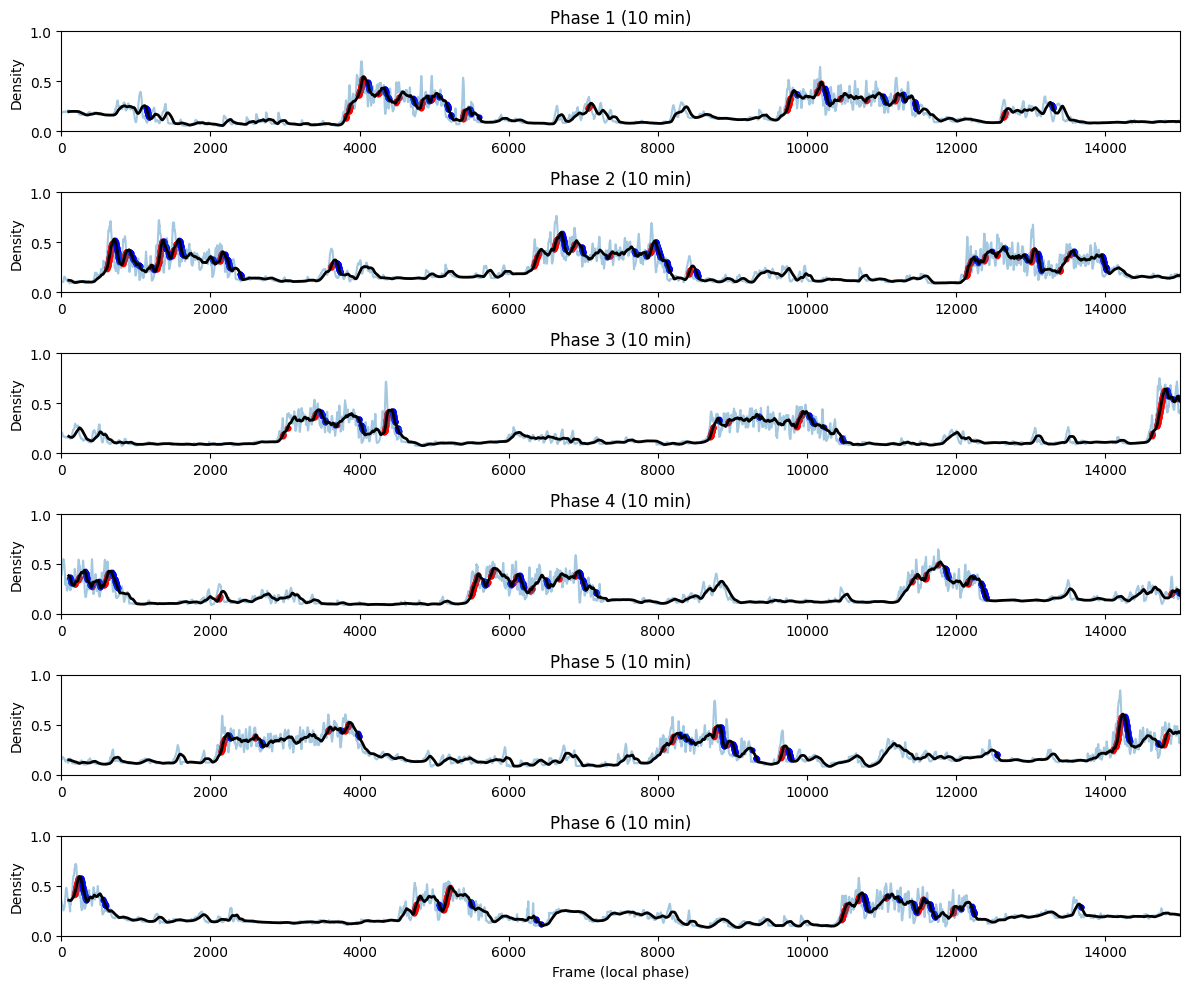

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(x, w):
    return np.convolve(x, np.ones(w)/w, mode="valid")

num_phases = 6
frames_per_phase = len(df) // num_phases

WINDOW = 100
DELTA_TH = 0.002

fig, axes = plt.subplots(num_phases, 1, figsize=(12, 10))

for i in range(num_phases):
    start = i * frames_per_phase
    end = (i + 1) * frames_per_phase if i < num_phases - 1 else len(df)

    y = df["density"].iloc[start:end].values
    x = np.arange(len(y))

    # Smooth
    y_ma = moving_average(y, WINDOW)
    x_ma = np.arange(len(y_ma)) + WINDOW

    # First difference of smoothed signal
    delta = np.diff(y_ma)

    up_x, up_y = [], []
    down_x, down_y = [], []

    for t, d in enumerate(delta):
        if d > DELTA_TH:
            up_x.append(x_ma[t])
            up_y.append(y_ma[t])
        elif d < -DELTA_TH:
            down_x.append(x_ma[t])
            down_y.append(y_ma[t])

    # Plot
    axes[i].plot(x, y, alpha=0.4, label="Raw")
    axes[i].plot(x_ma, y_ma, color="black", linewidth=2, label="MA")
    axes[i].scatter(up_x, up_y, color="red", s=10, label="Up trend")
    axes[i].scatter(down_x, down_y, color="blue", s=10, label="Down trend")

    axes[i].set_ylim(0, 1)
    axes[i].set_xlim(0, len(x))
    axes[i].set_ylabel("Density")
    axes[i].set_title(f"Phase {i+1} (10 min)")

axes[-1].set_xlabel("Frame (local phase)")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from collections import deque

WINDOW = 100
DELTA_TH = 0.002

buffer = deque(maxlen=WINDOW)
prev_ma = None

def update_density(frame_id, density):
    global prev_ma

    buffer.append(density)

    # wait until buffer is full
    if len(buffer) < WINDOW:
        return

    # moving average (online)
    ma = sum(buffer) / WINDOW

    if prev_ma is not None:
        delta = ma - prev_ma

        if delta > DELTA_TH:
            # print(f"[UP TREND]   frame={frame_id}, ma={ma:.3f}, delta={delta:.4f}")
            return 1

        elif delta < -DELTA_TH:
            # print(f"[DOWN TREND] frame={frame_id}, ma={ma:.3f}, delta={delta:.4f}")
            return 1

        else:
            return -1

    prev_ma = ma

prev_state = None
temp = deque(maxlen=WINDOW)
for _, row in df.iterrows():
    state = update_density(row["frame_id"], row["density"])
    temp.append(state)
    
    if len(temp) == WINDOW:
        total = sum(temp)
        if total > 0:
            print(f"Overall UP TREND at frame {row['frame_id']}")
        elif total < 0:
            print(f"Overall DOWN TREND at frame {row['frame_id']}")
        else:
            print(f"Overall STABLE at frame {row['frame_id']}")

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'